# Personas Creation

Our approach aligns closely with the input preparation model proposed by David W. Embley ([2021](https://doi.org/10.1007/978-3-030-88358-4_6)). We structure our data around _personas_, defined as "each mention instance of a person in a document" (p. 66), as a foundational step toward probabilistic record linkage (PRL). Each _persona_ is created by ingesting available individual metadata (such as name, last name, birth date), associating the person with a sacramental event (baptism, marriage, or burial). The relationship between personas is established by their participation at the event (e.g., as father, mother, godfather, witness).

## Personas Data Structure

The `personas` data structure is very straightforward:

- event_idno: unique semantically meaningful identifier for the event
- persona_idno: unique semantically meaningful identifier for the persona
- persona_type: role of the persona in the event (e.g., baptized, father, mother, witness)
- name: first name of the persona
- last_name: last name of the persona
- birth_date: birth date of the persona
- birth_place: birth place of the persona
- resident_in: persona residence at the time of the event
- gender: inferred gender of the persona
- social_condition: harmonized social condition of the persona
- legitimacy_status: harmonized legitimacy status of the persona
- marital_status: harmonized marital status of the persona


Identification of individuals is done by parsing one or a list of dataframes with the clean data, and processing the data using the `Persona` class. Results are stored in `data/interim/personas_extracted.csv` for testing, and in `data/clean/personas.csv` for production.

## Data Extraction

We begin by loading the cleaned sacramental records and extracting persona instances using the `PersonaExtractor` class. This process creates individual persona records for each person mentioned in the historical documents, preserving their role in each event.

In [1]:
import pandas as pd
from actions.extractors import Persona

In [2]:
bautismos = pd.read_csv("../data/clean/bautismos_clean.csv")
entierros = pd.read_csv("../data/clean/entierros_clean.csv")
matrimonios = pd.read_csv("../data/clean/matrimonios_clean.csv")

In [3]:
extractor = Persona.PersonaExtractor([bautismos, matrimonios, entierros])
personas = extractor.extract_personas()

personas.describe(include='all')

,event_idno,original_identifier,persona_type,name,birth_place,birth_date,legitimacy_status,lastname,persona_idno,social_condition,marital_status,resident_in,death_place,death_date,gender
count,47072,47072,47072,46999,5378,8596,11866,46762,47072,9643,4275,925,1513,2114,47072
unique,10180,10179,14,4286,53,7001,2,2616,47072,7,3,19,7,1813,6
top,matrimonio-490,APAucará-LM-L001_M490,mother,mariano,pampamarca,1901-09-04,legitimo,quispe,persona-1,indio,soltero,pampamarca,aucará,1871-11-04,male
freq,12,12,7614,1556,1919,8,9104,2712,1,5654,2779,292,1016,7,20150


### Initial Exploration

Before conducting detailed quality assessment, we examine the basic structure and distribution of persona types in the extracted dataset.

In [4]:
personas.to_csv("../data/clean/personas.csv", index=False)

In [5]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47072 entries, 0 to 47071
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   event_idno           47072 non-null  object
 1   original_identifier  47072 non-null  object
 2   persona_type         47072 non-null  object
 3   name                 46999 non-null  object
 4   birth_place          5378 non-null   object
 5   birth_date           8596 non-null   object
 6   legitimacy_status    11866 non-null  object
 7   lastname             46762 non-null  object
 8   persona_idno         47072 non-null  object
 9   social_condition     9643 non-null   object
 10  marital_status       4275 non-null   object
 11  resident_in          925 non-null    object
 12  death_place          1513 non-null   object
 13  death_date           2114 non-null   object
 14  gender               47072 non-null  object
dtypes: object(15)
memory usage: 5.4+ MB


## Quality Assessment

To evaluate the suitability of the extracted personas for probabilistic record linkage, we assess data completeness across multiple dimensions: names, parental linkages, temporal information, spatial attributes, and social/legal status markers.

Names are critical identifiers for record linkage. We assess the completeness of both first names and surnames across all persona types.

### Name Completeness

In [6]:
name_completeness = personas.loc[(personas['name'].isna()) | (personas['lastname'].isna())]
name_completeness.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 62 to 46928
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   event_idno           383 non-null    object
 1   original_identifier  383 non-null    object
 2   persona_type         383 non-null    object
 3   name                 310 non-null    object
 4   birth_place          35 non-null     object
 5   birth_date           52 non-null     object
 6   legitimacy_status    41 non-null     object
 7   lastname             73 non-null     object
 8   persona_idno         383 non-null    object
 9   social_condition     55 non-null     object
 10  marital_status       20 non-null     object
 11  resident_in          0 non-null      object
 12  death_place          26 non-null     object
 13  death_date           53 non-null     object
 14  gender               383 non-null    object
dtypes: object(15)
memory usage: 47.9+ KB


In [7]:
name_completeness['persona_type'].value_counts()

persona_type
mother               83
deceased             53
father_of_husband    45
father_of_wife       45
father               44
godmother            27
godfather            25
godparent            13
wife                 13
witness              10
husband               9
mother_of_wife        7
mother_of_husband     5
baptized              4
Name: count, dtype: int64

In [8]:
# Percentage of missing names
total_personas = len(personas)
missing_names = len(name_completeness)
percentage_missing_names = (missing_names / total_personas) * 100
print(f"Percentage of personas with missing names: {percentage_missing_names:.2f}%")

Percentage of personas with missing names: 0.81%


In [9]:
missing_firstnames = personas.loc[personas['name'].isna()]
percentage_missing_firstnames = (len(missing_firstnames) / total_personas) * 100
print(f"Percentage of personas with missing firstnames: {percentage_missing_firstnames:.2f}%")

Percentage of personas with missing firstnames: 0.16%


In [10]:
missing_surnames = personas.loc[personas['lastname'].isna()]
percentage_missing_surnames = (len(missing_surnames) / total_personas) * 100
print(f"Percentage of personas with missing lastnames: {percentage_missing_surnames:.2f}%")

Percentage of personas with missing lastnames: 0.66%


### Parental Linkage Completeness

For personas identified as children (baptized, deceased children, etc.), we assess whether their parents are properly linked in the dataset. The expectation differs by legitimacy status: legitimate children should have both parents recorded, while illegitimate children require at least one parent.

In [11]:
legitimate_sons = personas.loc[personas['legitimacy_status'] == 'legitimo']
ilegitimate_sons = personas.loc[personas['legitimacy_status'] == 'ilegitimo']

sons_types = legitimate_sons['persona_type'].unique().tolist()

# filter ilegitimate sons by sons types to avoid including other ilegitimate personas
ilegitimate_sons = ilegitimate_sons.loc[ilegitimate_sons['persona_type'].isin(sons_types)]

print("Legitimate Sons Persona Types and Counts:")
print(legitimate_sons['persona_type'].value_counts())
print("\nIlegitimate Sons Persona Types and Counts:")
print(ilegitimate_sons['persona_type'].value_counts())

Legitimate Sons Persona Types and Counts:
persona_type
baptized    5483
wife        1267
husband     1248
deceased    1106
Name: count, dtype: int64

Ilegitimate Sons Persona Types and Counts:
persona_type
baptized    810
deceased    201
wife        170
husband     165
Name: count, dtype: int64


In [12]:
def check_parents_completeness(sons_df, personas_df, legitimacy='leg'):
    # Get unique event_idno from sons
    event_ids = sons_df['event_idno'].unique()
    
    # Filter personas to only relevant events
    relevant_personas = personas_df[personas_df['event_idno'].isin(event_ids)]
    
    # Check for father and mother presence by event
    events_with_father = set(relevant_personas[relevant_personas['persona_type'].str.contains('father', na=False)]['event_idno'])
    events_with_mother = set(relevant_personas[relevant_personas['persona_type'].str.contains('mother', na=False)]['event_idno'])
    
    if legitimacy == 'leg':
        # For legitimate sons, both parents should be present
        # Incomplete if missing father OR missing mother
        events_missing_father = set(event_ids) - events_with_father
        events_missing_mother = set(event_ids) - events_with_mother
        incomplete_events = events_missing_father | events_missing_mother
    elif legitimacy == 'ileg':
        # For illegitimate sons, at least one parent should be present
        # Incomplete if missing BOTH father AND mother
        incomplete_events = set(event_ids) - events_with_father - events_with_mother
    else:
        raise ValueError("Legitimacy must be 'leg' or 'ileg'")
    
    # Get sons with incomplete parents
    incomplete_sons = sons_df[sons_df['event_idno'].isin(incomplete_events)]
    return incomplete_sons

incomplete_legit_parents = check_parents_completeness(legitimate_sons, personas)
incomplete_ilegit_parents = check_parents_completeness(ilegitimate_sons, personas, legitimacy='ileg')

print(f"Number of legitimate sons with incomplete parents: {len(incomplete_legit_parents)}")
print(f"Number of ilegitimate sons with incomplete parents: {len(incomplete_ilegit_parents)}")

Number of legitimate sons with incomplete parents: 42
Number of ilegitimate sons with incomplete parents: 9


The results show excellent parental linkage quality:

- **Legitimate personas** (9,110 total): Only 0.46% (42 cases) have incomplete parental records
- **Illegitimate personas** (1,310 total): Only 0.68% (9 cases) lack at least one parent

This high completeness rate indicates that the extraction process successfully preserved family relationships recorded in the sacramental registers.

### Temporal Completeness

We assess the availability of birth and death dates, which are essential for temporal reasoning in record linkage.

In [13]:
nobirthdate = personas.loc[personas['birth_date'].isna()]
personas_size = len(personas)
nobirthdate_size = len(nobirthdate)
percentage_nobirthdate = (nobirthdate_size / personas_size) * 100
print(f"Percentage of personas with missing birth dates: {percentage_nobirthdate:.2f}%")
nobirthdate['persona_type'].value_counts()

Percentage of personas with missing birth dates: 81.74%


persona_type
mother               7614
father               7369
witness              4249
godparent            3260
godmother            3251
godfather            3012
wife                 1470
mother_of_wife       1459
husband              1441
mother_of_husband    1439
father_of_wife       1438
father_of_husband    1410
baptized              978
deceased               86
Name: count, dtype: int64

In [14]:
nodeathdate = personas.loc[personas['death_date'].isna()]
nodeathdate_size = len(nodeathdate)
percentage_nodeathdate = (nodeathdate_size / personas_size) * 100
print(f"Percentage of personas with missing death dates: {percentage_nodeathdate:.2f}%")
nodeathdate['persona_type'].value_counts()

Percentage of personas with missing death dates: 95.51%


persona_type
mother               7614
father               7369
baptized             6340
witness              4249
godparent            3260
godmother            3251
godfather            3012
wife                 2060
husband              2051
mother_of_wife       1459
mother_of_husband    1439
father_of_wife       1438
father_of_husband    1410
deceased                6
Name: count, dtype: int64

### Spatial Completeness

Birth and death places provide geographic context for mobility analysis and help disambiguate between individuals with similar names.

In [15]:
nonbirthplace = personas.loc[personas['birth_place'].isna()]
nonbirthplace_size = len(nonbirthplace)
percentage_nonbirthplace = (nonbirthplace_size / personas_size) * 100
print(f"Percentage of personas with missing birth places: {percentage_nonbirthplace:.2f}%")
nonbirthplace['persona_type'].value_counts()

Percentage of personas with missing birth places: 88.57%


persona_type
mother               7614
father               7369
baptized             4532
witness              4249
godparent            3260
godmother            3251
godfather            3012
mother_of_wife       1459
mother_of_husband    1439
father_of_wife       1438
father_of_husband    1410
wife                 1154
husband              1114
deceased              393
Name: count, dtype: int64

In [16]:
nodeathplace = personas.loc[personas['death_place'].isna()]
nodeathplace_size = len(nodeathplace)
percentage_nodeathplace = (nodeathplace_size / personas_size) * 100
print(f"Percentage of personas with missing death places: {percentage_nodeathplace:.2f}%")
nodeathplace['persona_type'].value_counts()

Percentage of personas with missing death places: 96.79%


persona_type
mother               7614
father               7369
baptized             6340
witness              4249
godparent            3260
godmother            3251
godfather            3012
wife                 2060
husband              2051
mother_of_wife       1459
mother_of_husband    1439
father_of_wife       1438
father_of_husband    1410
deceased              607
Name: count, dtype: int64

In [17]:
# personas with both birth and death places present
birth_and_death_places = personas.loc[personas['birth_place'].notna() & personas['death_place'].notna()]
birth_and_death_places_size = len(birth_and_death_places)
percentage_birth_and_death_places = (birth_and_death_places_size / personas_size) * 100
print(f"Percentage of personas with both birth and death places present: {percentage_birth_and_death_places:.2f}%")
birth_and_death_places['persona_type'].value_counts()

Percentage of personas with both birth and death places present: 2.59%


persona_type
deceased    1219
Name: count, dtype: int64

### Attribute Completeness

We examine the completeness of harmonized social and legal status attributes (legitimacy, marital status, social condition), which provide contextual information that can strengthen or weaken linkage hypotheses.

In [18]:
legitimacy_missing = personas.loc[personas['legitimacy_status'].isna()]
legitimacy_missing_size = len(legitimacy_missing)
percentage_legitimacy_missing = (legitimacy_missing_size / personas_size) * 100
print(f"Percentage of personas with missing legitimacy status: {percentage_legitimacy_missing:.2f}%")
legitimacy_missing['persona_type'].value_counts()

Percentage of personas with missing legitimacy status: 74.79%


persona_type
mother               7608
father               7365
witness              4249
godparent            3258
godmother            3248
godfather            3008
mother_of_wife       1113
father_of_wife       1093
mother_of_husband    1085
father_of_husband    1058
deceased              813
husband               638
wife                  623
baptized               47
Name: count, dtype: int64

In [19]:
marital_status_missing = personas.loc[personas['marital_status'].isna()]
marital_status_missing_size = len(marital_status_missing)
percentage_marital_status_missing = (marital_status_missing_size / personas_size) * 100
print(f"Percentage of personas with missing marital status: {percentage_marital_status_missing:.2f}%")
marital_status_missing['persona_type'].value_counts()

Percentage of personas with missing marital status: 90.92%


persona_type
mother               7550
father               7362
baptized             6340
witness              4249
godmother            3250
godparent            3241
godfather            3011
mother_of_wife       1459
mother_of_husband    1438
father_of_wife       1438
father_of_husband    1410
deceased              917
wife                  586
husband               546
Name: count, dtype: int64

In [20]:
social_condition_missing = personas.loc[personas['social_condition'].isna()]
social_condition_missing_size = len(social_condition_missing)
percentage_social_condition_missing = (social_condition_missing_size / personas_size) * 100
print(f"Percentage of personas with missing social condition: {percentage_social_condition_missing:.2f}%")
social_condition_missing['persona_type'].value_counts()

Percentage of personas with missing social condition: 79.51%


persona_type
mother               6715
father               6564
baptized             4338
witness              4249
godparent            2967
godfather            2922
godmother            2901
wife                 1196
husband              1145
mother_of_wife        955
father_of_wife        938
mother_of_husband     938
father_of_husband     917
deceased              684
Name: count, dtype: int64

### Aggregate Completeness Metrics

Beyond individual field completeness, we calculate overall completeness scores to understand the general quality of persona records. We compute both a simple completeness score (proportion of non-null fields) and a weighted score that prioritizes critical fields for record linkage.

#### Simple Completeness Score

The simple score treats all fields equally, providing a general measure of data richness.

In [21]:
personas['completeness_score'] = personas.notna().sum(axis=1) / len(personas.columns)
personas.groupby('persona_type')['completeness_score'].mean().sort_values(ascending=False)

persona_type
deceased             0.821415
husband              0.656038
wife                 0.651748
baptized             0.629243
mother_of_husband    0.506092
mother_of_wife       0.505186
father_of_husband    0.504492
father_of_wife       0.503755
mother               0.474424
father               0.473651
godmother            0.473372
godparent            0.472822
godfather            0.468216
witness              0.466510
Name: completeness_score, dtype: float64

#### Weighted Completeness Score

The weighted score assigns higher importance to fields crucial for record linkage (names, dates) and lower weights to supplementary attributes (social condition, residence). This reflects the differential utility of fields in matching algorithms.

In [22]:
weights = {
    'name': 0.15,
    'lastname': 0.15,
    'birth_date': 0.125,
    'death_date': 0.125,
    'birth_place': 0.10,
    'death_place': 0.10,
    'legitimacy_status': 0.05,
    'marital_status': 0.05,
    'social_condition': 0.05,
    'gender': 0.05,
    'resident_in': 0.05
}

def weighted_completeness(row, weights):
    score = 0.0
    for col, w in weights.items():
        if pd.notna(row[col]):
            score += w
    return score

personas['weighted_completeness'] = personas.apply(weighted_completeness, axis=1, weights=weights)
personas.groupby('persona_type')['weighted_completeness'].mean().sort_values(ascending=False)

persona_type
deceased             0.836722
baptized             0.549558
husband              0.536738
wife                 0.531650
mother_of_husband    0.379222
mother_of_wife       0.378410
father_of_husband    0.375177
father_of_wife       0.374687
mother               0.354728
father               0.354641
godparent            0.354218
godmother            0.354199
godfather            0.350332
witness              0.349647
Name: weighted_completeness, dtype: float64

#### Comparison of Completeness Metrics

Visualizing the relationship between simple and weighted completeness reveals how different persona types vary in their possession of high-priority fields.

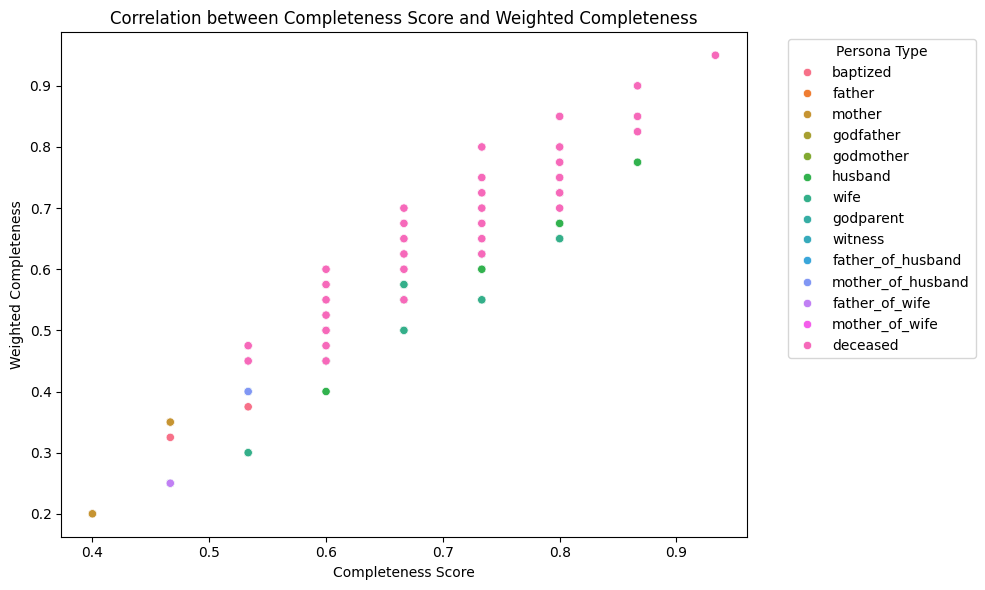

In [23]:
# plot correlation between completeness_score and weighted_completeness
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=personas, x='completeness_score', y='weighted_completeness', hue='persona_type')
plt.title('Correlation between Completeness Score and Weighted Completeness')
plt.xlabel('Completeness Score')
plt.ylabel('Weighted Completeness')
plt.legend(title='Persona Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Summary and Implications

The quality assessment reveals that the persona extraction process successfully preserved historical information with high fidelity:

- **Name completeness** is excellent for most persona types, with missing names concentrated in expected categories (e.g., godparents, witnesses)
- **Parental linkages** are nearly complete (>99%) for both legitimate and illegitimate children, enabling family reconstruction
- **Temporal and spatial data** show variable completeness depending on persona type, reflecting the original documentary practices
- **Weighted completeness scores** indicate that core linkage fields (names, dates) are well-populated across persona types

These results suggest that the dataset is well-suited for probabilistic record linkage, with sufficient information density to support robust matching algorithms while retaining the historical nuances present in the original sacramental registers.